In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import transform

In [29]:
image = cv2.imread('/home/shanu/Desktop/test_images/image.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [3]:
def rescaling(image):
    max_dimension = max(image.shape)
    scale= 640.0/max_dimension
    image = cv2.resize(image,None,fx=scale,fy=scale,interpolation = cv2.INTER_AREA)
    return image

In [4]:
def printImage(image):
    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
def printAndCompare(image1,image2):
# numpy_horizontal = np.hstack((image, grey_3_channel))
    concatenateHorizontal = np.concatenate((image1,image2),axis = 1)
    cv2.imshow('concatenateHor',concatenateHorizontal)
    k=cv2.waitKey(0)
    cv2.destroyAllWindows()
    return k

In [ ]:
#using blob detection
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
test_img = rescaling(image)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# integral_image = transform.integral.integral_image(gray)
# blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# # Compute radii in the 3rd column.
# blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

# blobs_list = [blobs_log, blobs_dog, blobs_doh]
# colors = ['yellow', 'lime', 'red']
# titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
#           'Determinant of Hessian']
# sequence = zip(blobs_list, colors, titles)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True,
#                          subplot_kw={'adjustable': 'box-forced'})
# ax = axes.ravel()

# for idx, (blobs, color, title) in enumerate(sequence):
#     ax[idx].set_title(title)
#     ax[idx].imshow(image, interpolation='nearest')
#     for blob in blobs:
#         y, x, r = blob
#         c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
#         ax[idx].add_patch(c)
#     ax[idx].set_axis_off()

# difference of guassian blob detection 
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)

blobs = [blobs_dog]
colors = ['red']
titles = ['Difference of Gaussian']
sequence = zip(blobs, colors, titles)

for blobs, color, title in sequence:
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)

plt.tight_layout()
plt.show()

# image -> binarisation using masking(by selecting the min and max range of hsv channel) -> morphological transformation to remove the noise -> corner detection using harris corner -> using box filter to merge the corners

In [ ]:
img = rescaling(image)
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# masking image for separating the grid portion
image_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
min_val = np.array([0,0,0],np.uint8)
max_val = np.array([255,120,120],np.uint8)
mask = cv2.inRange(image_hsv,min_val,max_val)
#inverting the mask
invert_masked = cv2.bitwise_not(mask)
printAndCompare(gray,invert_masked)
#boolean and with the original image
masked_image = cv2.cvtColor(invert_masked,cv2.COLOR_GRAY2RGB)
masked_image = cv2.bitwise_and(img,masked_image)
masked_image = cv2.addWeighted(masked_image,1,cv2.cvtColor(invert_masked,cv2.COLOR_GRAY2BGR),0,1)
# printImage(masked_image)
blur = cv2.GaussianBlur(masked_image,(5,5),0.5,0.5)
printImage(blur)
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
closing = cv2.morphologyEx(masked_image, cv2.MORPH_CLOSE, kernel)
printImage(closing)
applying harris corner detection
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#passing the smooth image for corner detection
blur = cv2.GaussianBlur(gray,(7,7),0.5,0.5)
dst = cv2.cornerHarris(blur,2,3,0.04)
# print dst.shape
dst = cv2.dilate(dst,None)
#thresholding corners as 25 percent of max quality 
img[dst>0.025*dst.max()]=[0,0,255]
filter_blur = cv2.GaussianBlur(img,(7,7),0.5,0.5)
cv2.boxFilter(img, -1, (3,3), img, (-1,-1), False, cv2.BORDER_DEFAULT)
# cv2.imwrite('harrisCorners_one.png',img)
printImage(img)
# cv2.imwrite('blurredCorner.png',img)  img , k = tuneParameter(equalized,img,sizeBlock,sizeKernel,3)

In [6]:
def tuneParameter(img,block_size,kernel_size,boxFilter_size,quality):
    eigenVals = cv2.cornerEigenValsAndVecs(img, block_size, kernel_size, cv2.BORDER_DEFAULT)
    edgeDensity = ((eigenVals[:,:,0]-eigenVals[:,:,1])**2)/((eigenVals[:,:,0]+eigenVals[:,:,1])**2+0.002)
    edgeDensity = cv2.dilate(edgeDensity,None)    
    normalizedEdgeDensity = cv2.normalize(edgeDensity, 0.0, 1.0, cv2.NORM_MINMAX)
    test_img2 = test_img.copy()
    test_img2[normalizedEdgeDensity>quality*normalizedEdgeDensity.max()]=[0,255,0]
    cv2.boxFilter(test_img2, -1, (boxFilter_size,boxFilter_size), test_img2, (-1,-1), False, cv2.BORDER_DEFAULT)
    k = printAndCompare(test_img,test_img2)
    return k,test_img2

In [9]:
test_img = rescaling(image)
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
equalized = clahe.apply(gray)
printImage(equalized)
desired_blockSize = []
desired_kernelSize = []
desired_filterSize = []
block_size = [i for i in range(4,10)] # size = 10
kernel_size = [j for j in range(3,11,2)] 
filter_size = [k for k in range(3,8)]
quality_factor = [m*0.1 for m in range(8,3,-1)]
count = 0
for sizeBlock in block_size:
    for sizeKernel in kernel_size:
        for sizeFilter in filter_size:
            for quality in quality_factor:
                k,img = tuneParameter(equalized,sizeBlock,sizeKernel,sizeFilter,quality)
                if k ==27:
                    count += 1 
                    desired_blockSize.append(sizeBlock)
                    desired_kernelSize.append(sizeKernel)
                    desired_filterSize.append(sizeFilter)
                    imageName = 'test_img' + str(count) + '.png'
                    cv2.imwrite(imageName,img)

In [ ]:
filtered_kernelSize = []
filtered_filterSize = []
filtered_blockSize = []
for sizeBlock in desired_blockSize:
    for sizeKernel in desired_kernelSize:
        for sizeFilter in desired_filterSize:
            for quality in quality_factor:
                k,img = tuneParameter(equalized,sizeBlock,sizeKernel,sizeFilter,quality)
                if k ==27:
                    count += 1 
                    filered_blockSize.append(sizeBlock)
                    filtered_kernelSize.append(sizeKernel)
                    filtered_filterSize.append(sizeFilter)
                    imageName = 'test_img' + str(count) + '.png'
                    cv2.imwrite(imageName,img)

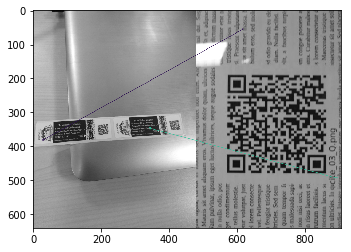

(<matplotlib.image.AxesImage at 0x7f0425ed09d0>, None)

In [45]:
img1 = cv2.imread('/home/shanu/Desktop/test_images/image.jpeg',0)
img2 = cv2.imread('/home/shanu/Desktop/test_images/IMG.jpg',0)          # queryImage
img1 = rescaling(img1)
img2 = rescaling(img2)
sift = cv2.xfeatures2d.SIFT_create()
(kps1, descs1) = sift.detectAndCompute(img1, None)
sift = cv2.xfeatures2d.SIFT_create()
(kps2, descs2) = sift.detectAndCompute(img2, None)
#create object of matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv2.drawMatchesKnn expects list of lists as matches.
img2 = cv2.drawMatchesKnn(img1,kps1,img2,kps2,good,img2,flags=2)
plt.imshow(img2),plt.show()
# img = cv2.drawKeypoints(gray, kps, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imwrite('keyPoint.png',img)
# printImage(img2)
# print type(kps)

32

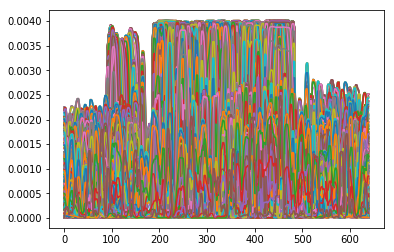

In [22]:
test_img = rescaling(image)
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),3,3)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
equalized = clahe.apply(gray)
# printImage(equalized)
dst = cv2.cornerHarris(equalized,10,3,0.04)
# as kernel size is increased the detected edges increases
eigenVals = cv2.cornerEigenValsAndVecs(blur, 7, 5, cv2.BORDER_DEFAULT)
dst = cv2.dilate(dst,None)
# 6 channels two eigen values , corresponding eigen vectors
cornerDensity = 4*eigenVals[:,:,0]*eigenVals[:,:,1]/((eigenVals[:,:,0]+eigenVals[:,:,1])**2+0.002)
edgeDensity = ((eigenVals[:,:,0]-eigenVals[:,:,1])**2)/((eigenVals[:,:,0]+eigenVals[:,:,1])**2+0.002)
edgeDensity = cv2.dilate(edgeDensity,None)
cornerDensity = cv2.dilate(cornerDensity,None)
normalizedCornerDensity = cv2.normalize(cornerDensity , 0.0, 1.0, cv2.NORM_MINMAX)
normalizedEdgeDensity = cv2.normalize(edgeDensity, 0.0, 1.0, cv2.NORM_MINMAX)

# plt.subplot(222)
plt.plot(normalizedEdgeDensity)
plt.show

test_img1 = test_img.copy()
test_img2 = test_img.copy()
# test_img[normalizedCornerDensity>0.2*normalizedCornerDensity.max()]=[0,0,255]
test_img1[dst>0.02*dst.max()] = [255,0,0]
test_img2[normalizedEdgeDensity>0.8*normalizedEdgeDensity.max()]=[0,255,0]
# # printImage(equalized)
cv2.boxFilter(test_img1, -1, (5,5), test_img1, (-1,-1), False, cv2.BORDER_DEFAULT)
cv2.boxFilter(test_img2, -1, (5,5), test_img2, (-1,-1), False, cv2.BORDER_DEFAULT)
# printImage(test_img2)
printAndCompare(test_img,test_img2)

In [ ]:
# def find(img, window_size, k, thresh):
###edge density and corner density paramaters
window_size = 14
img = gray
#calculating gradients Ix,Iy
dy, dx = np.gradient(img)
Ixx = dx**2
Ixy = dy*dx
Iyy = dy**2
height = img.shape[0]
width = img.shape[1]
offset = window_size/2
#structure matrix M = (Ixx,Ixy)
#                     (Ixy,Iyy)
structure_row = []
edgeDensity = []
cornerDensity = []
for y in range(offset, height-offset):
    structure_col = []
    edge_density = [][dst>0.025*dst.max()
    corner_density = []
    for x in range(offset, width-offset):
#         Calculate sum of squares
        windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
        windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
        windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
        Cxx = windowIxx.sum()
        Cxy = windowIxy.sum()
        Cyy = windowIyy.sum()
        #calculating edge density and corner density params
        m1 = ((Cxx-Cyy)**2 + 4*(Cxy)**2)/((Cxx+Cyy)**2 + 0.03)
        edge_density.append(m1)
        m2 = (4*(Cxx*Cyy - Cxy*2))/((Cxx+Cyy)**2 + 0.03)
        corner_density.append(m2) 
        structure = np.stack([[Cxx,Cxy],[Cxy,Cyy]]) 
        structure_col.append(structure)
#         print structure
    edge_density = np.array(edge_density)
    corner_density = np.array(corner_density)
    structure_col = np.array(structure_col)
    structure_row.append(structure_col)
    edgeDensity.append(edge_density)
    cornerDensity.append(corner_density)
structure_row = np.array(structure_row)
edgeDensity = np.array(edgeDensity)
cornerDensity = np.array(cornerDensity)

In [ ]:
#masking using brightness value feature of qr grid
img = rescaling(image)
hsv_image = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
printImage(hsv_image)
hue_channel = hsv_image[:,:,0]
sat_channel = hsv_image[:,:,1]
print np.max(sat_channel)
val_channel = hsv_image[:,:,2]
print np.max(val_channel)
# hist2d = cv2.calcHist(hsv_image,[2,1],None,[255,255],[0,255,0,255])
# plt.imshow(hist2d,interpolation = 'nearest')
plt.plot(hist2d,'r')
plt.show
#masking based on brightness level
min_saturation = np.array([0,0,0],np.uint8)
max_saturation = np.array([180,140,100],np.uint8)
mask = cv2.inRange(hsv_image,min_saturation,max_saturation)
mask_invert = cv2.bitwise_not(mask)
printImage(mask_invert)
# mask_bgr = cv2.cvtColor(mask,cv2.COLOR_HSV2RGB)
mean_val = np.mean(val_channel)
std_val = np.std(val_channel)
mean_sat = np.mean(sat_channel)
std_sat = np.std(sat_channel)
print mean_sat,std_sat
print mean_val,std_val


In [ ]:
image_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
blue_min = np.array([100,100,100],np.uint8)
blue_max = np.array([140,255,255],np.uint8)
mask = cv2.inRange(image_hsv,blue_min,blue_max)
plt.subplot(221)
plt.imshow(mask,cmap = 'gray')
masked_image = cv2.bitwise_not(mask)
print masked_image
masked_upstate = cv2.cvtColor(masked_image,cv2.COLOR_GRAY2BGR)
masked_upstate = cv2.bitwise_and(image,masked_upstate)
weighted_masked = cv2.addWeighted(masked_upstate,1,cv2.cvtColor(masked_image,cv2.COLOR_GRAY2BGR),1,0)
printImage(masked_image)

In [ ]:
CMYK_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGBA)
# plt.figure(figsize = (8,7))
# plt.plot(black_channel,'b')
# plt.show
# blur = cv2.GuasianBlur(image,)
tmp = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
print type(tmp[1,1,0])
# print type(black_channel[1,1])

In [ ]:
print image.shape
average_color_per_row = np.average(image, axis=0)
average_color = np.average(average_color_per_row, axis=0)
average_color = np.uint8(average_color)
new_image = np.array([[average_color]*500]*500,np.uint8)
printImage(new_image)

In [ ]:
lists = [1,2,2,4]
for x, element in enumerate(lists):
    print x+1, element 
    

In [ ]:
_dict = {1:'first', 2:'second',3:'third'}
print _dict.get(3,'na')
print type(_dict.items())

In [ ]:
from math import sqrt
sets = {int(sqrt(x)) for x in range(30)}

In [ ]:
a = np.full((500,500,3),255.0,dtype=np.float32)
a= np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
print a.shape

In [ ]:
b = [0,1,2]
print a[b,(np.arange(3))]